Move up to parent dir

In [3]:
import os

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from pandas_profiling import ProfileReport

In [4]:
RAW_DATA_DIR = os.path.join("data", "raw", "stt")
RAW_RECORDINGS_DIR = os.path.join(RAW_DATA_DIR, "recordings")
RECORDINGS_FILE = os.path.join(
    RAW_DATA_DIR, "overview-of-recordings.csv"
)
STT_REPORT = os.path.join("reports", "stt")


In [5]:
def get_librosa_features(
    row: pd.Series,
) -> tuple[np.ndarray, int, float]:
    file_path = row.path
    audio, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(filename=file_path)
    return audio, sr, np.round(duration, 3)

def load_dataframe(filename: str, columns: list[str]) -> pd.DataFrame:
    df = pd.read_csv(filename, usecols=columns)
    df["path"] = df["file_name"].apply(
        lambda x: os.path.join(RAW_RECORDINGS_DIR, x)
    )
    return df

def transform_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df[["audio", "sr", "duration"]] = df.apply(
        lambda x: get_librosa_features(x),
        result_type="expand",
        axis=1,
    )
    return df


def load_train_val_test_data(folder_path: str) -> pd.DataFrame:
    train_df = pd.read_csv(os.path.join(folder_path, "train.csv"))
    val_df = pd.read_csv(os.path.join(folder_path, "val.csv"))
    test_df = pd.read_csv(os.path.join(folder_path, "test.csv"))

    train_df["split_type"] = "train"
    val_df["split_type"] = "val"
    test_df["split_type"] = "test"

    df = pd.concat([train_df, val_df, test_df], axis=0).reset_index(
        drop=True
    )
    df = transform_dataframe(df)
    return df

def evaluate_audio_sample(row: pd.Series) -> None:
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
    librosa.display.waveshow(row.audio, sr=row.sr, ax=ax[0])
    ax[0].set(title="Waveplot")
    ax[1].specgram(row.audio, Fs=row.sr)
    ax[0].set(ylabel="Amplitude", title="Waveplot")
    ax[1].set(
        xlabel="Time (seconds)",
        ylabel="Frequency (HZ)",
        title="Spectogram",
    )
    fig.suptitle(f"Text: {row.phrase}")
    plt.savefig(os.path.join(STT_REPORT, "audio_sample.png"))


def create_dir(file_path: str) -> None:
    os.makedirs(file_path, exist_ok=True)

def make_report(df: pd.DataFrame) -> ProfileReport:
    report = ProfileReport(df, title="STT Report", explorative=True)
    return report


def save_report(report: ProfileReport, file_path: str) -> None:
    report.to_file(os.path.join(file_path, "report.html"))

In [8]:
important_columns = [
    "audio_clipping",
    "overall_quality_of_the_audio",
    "quiet_speaker",
    "speaker_id",
    "file_name",
    "phrase",
    "prompt",
    "writer_id",
]
# Load main dataframe
df_full = load_dataframe(RECORDINGS_FILE, important_columns)
print(df_full.shape)
df_full.head()

(6661, 9)


,audio_clipping,overall_quality_of_the_audio,quiet_speaker,speaker_id,file_name,phrase,prompt,writer_id,path
0,no_clipping,3.33,audible_speaker,43453425,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495,data\raw\stt\recordings\1249120_43453425_58166...
1,light_clipping,3.33,audible_speaker,43719934,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126,data\raw\stt\recordings\1249120_43719934_43347...
2,no_clipping,3.33,audible_speaker,43719934,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353,data\raw\stt\recordings\1249120_43719934_53187...
3,no_clipping,3.33,audible_speaker,31349958,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034,data\raw\stt\recordings\1249120_31349958_55816...
4,no_clipping,4.67,audible_speaker,43719934,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495,data\raw\stt\recordings\1249120_43719934_82524...


In [20]:
# Train, val, test evaulation
df_train_val_test = load_train_val_test_data(RAW_DATA_DIR)
print(df_train_val_test.shape)

(6524, 6)


In [23]:
split_to_recordings = {"train": "recordings", "val": "recordings", "test": "recordings"}
df_train_val_test["file_name"] = df_train_val_test["path"].apply(lambda x: os.path.split(x)[1])
df_train_val_test.head()

,audio,sentence,path,split_type,sr,duration,path1,file_name
0,"[0.027893066, 0.028167725, 0.030944824, 0.0314...",My heart is pumping fast and I'm having a hard...,data\raw\stt\train\1249120_41150153_26529048.wav,train,48000,3.584,1249120_41150153_26529048.wav,1249120_41150153_26529048.wav
1,"[-0.0016784668, -0.0010375977, -3.0517578e-05,...",My shoulder hurts me so much,data\raw\stt\train\1249120_39740177_23857907.wav,train,48000,3.328,1249120_39740177_23857907.wav,1249120_39740177_23857907.wav
2,"[0.0011901855, 0.0014343262, 0.0010986328, 0.0...",I feel a bone-on-bone pain in my knees when I ...,data\raw\stt\train\1249120_39154234_92913190.wav,train,48000,7.936,1249120_39154234_92913190.wav,1249120_39154234_92913190.wav
3,"[0.0048828125, 0.0053100586, 0.0059509277, 0.0...",i have a great pain in my foot like thrombing ...,data\raw\stt\train\1249120_35197064_83362445.wav,train,48000,5.973,1249120_35197064_83362445.wav,1249120_35197064_83362445.wav
4,"[6.1035156e-05, 0.00012207031, 6.1035156e-05, ...",I have a sharp pain in my lower stomach.,data\raw\stt\train\1249120_20518958_80630181.wav,train,48000,4.779,1249120_20518958_80630181.wav,1249120_20518958_80630181.wav


In [25]:

# Merge dataframes
df = pd.merge(df_full, df_train_val_test, on="file_name", how="inner")
print(df.shape)


(6524, 16)


In [39]:
# Merge dataframe on path column

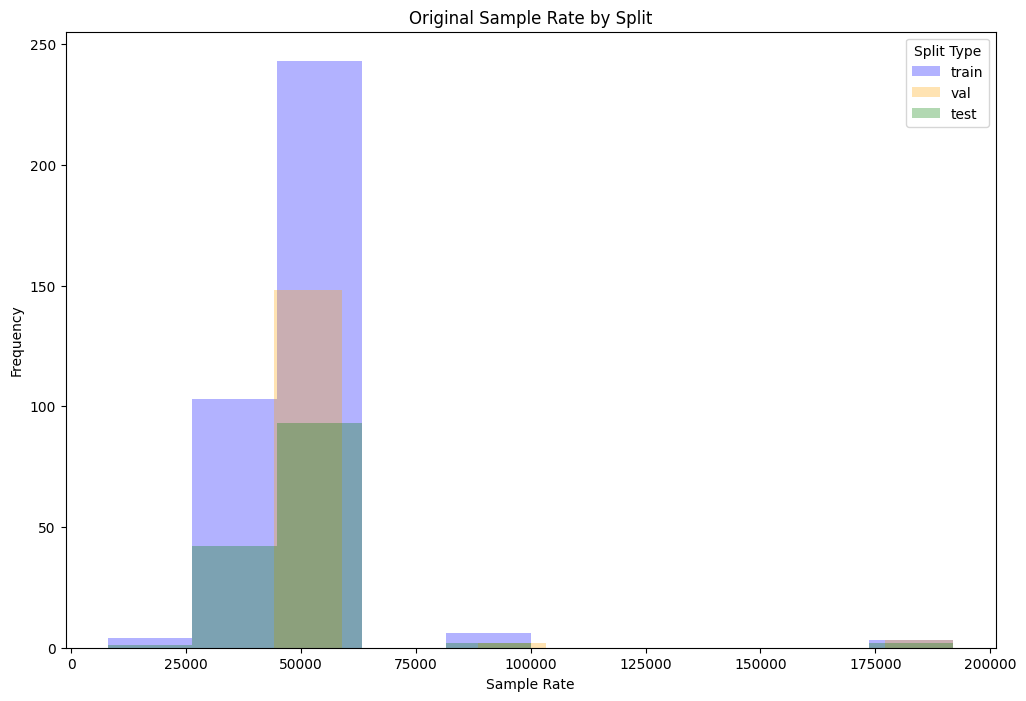

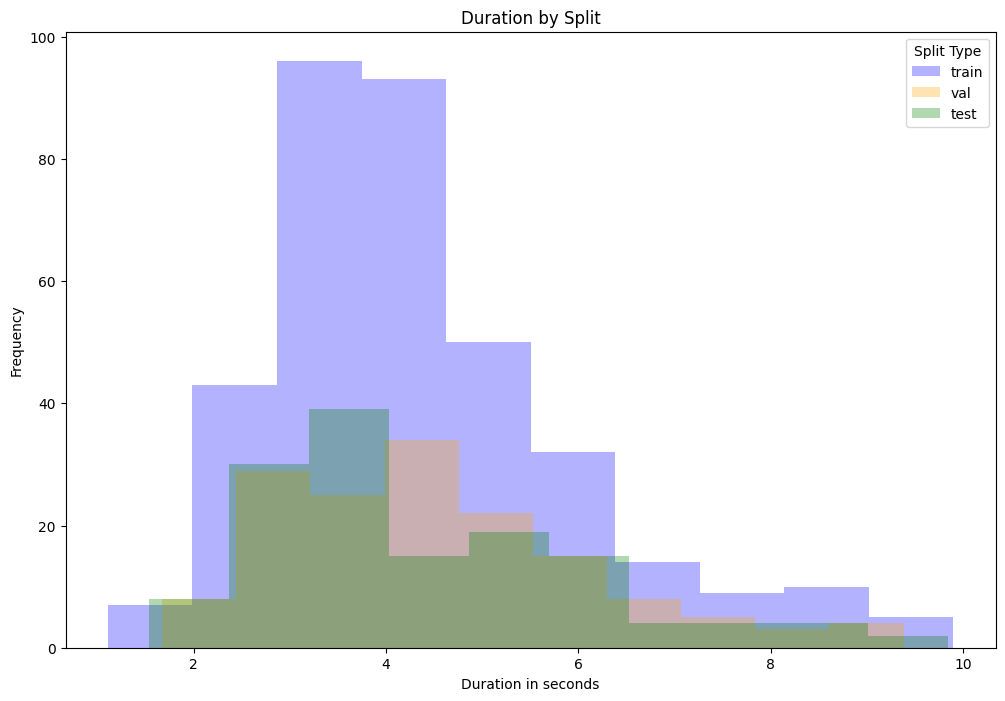

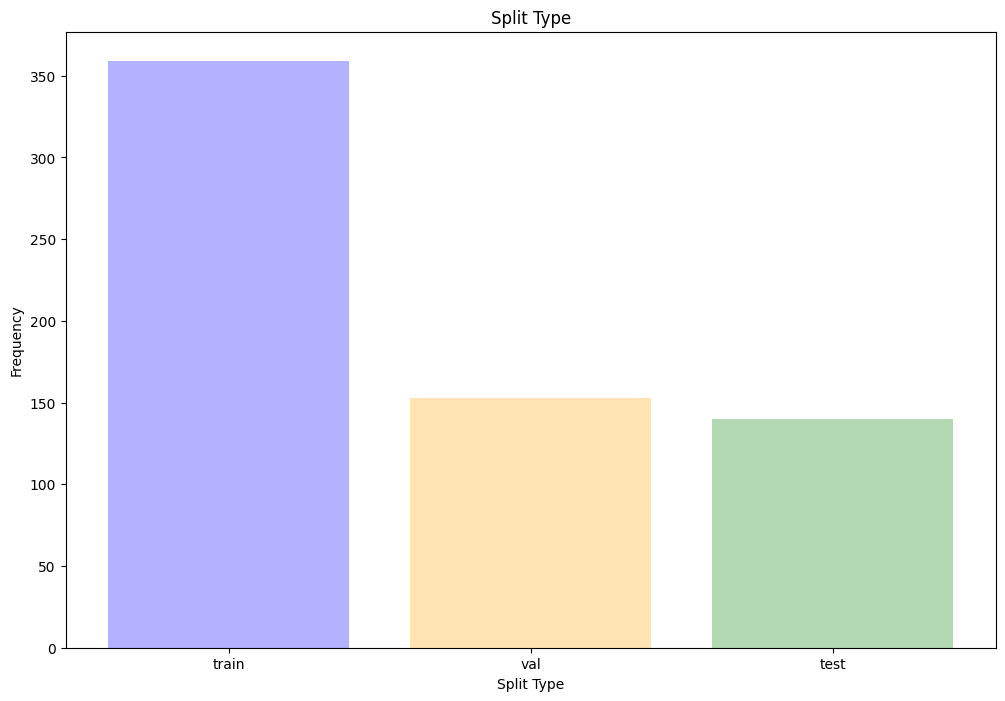

In [113]:
def create_charts(col_use: str, title: str, xlabel: str, ylabel: str, hist:bool) -> None:
    train = df.loc[df["split_type"] == "train", col_use]
    val = df.loc[df["split_type"] == "val", col_use]
    test = df.loc[df["split_type"] == "test", col_use]
    
    plt.figure(figsize=(12,8))
    
    if hist:
        # Add three histograms to one plot
        plt.hist(train, alpha=0.3, label='train', color='blue')
        plt.hist(val, alpha=0.3, label='val', color="orange")
        plt.hist(test, alpha=0.3, label='test', color="green")
        
        # Add legend
        plt.legend(title='Split Type')
    else:
        plt.bar(df["split_type"].unique(),
    height=df["split_type"].value_counts(),
    alpha=0.3,
    color=[
        "blue",
        "orange",
        "green",
    ],)
        
    # Add plot title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    
create_charts("sr", "Original Sample Rate by Split", "Sample Rate", "Frequency", True)
create_charts("duration", "Duration by Split", "Duration in seconds", "Frequency", True)
create_charts("split_type", "Split Type", "Split Type", "Frequency", False)
    